# Tagging and Extraction Using OpenAI functions

Allow us to extract structured data from unstructured text

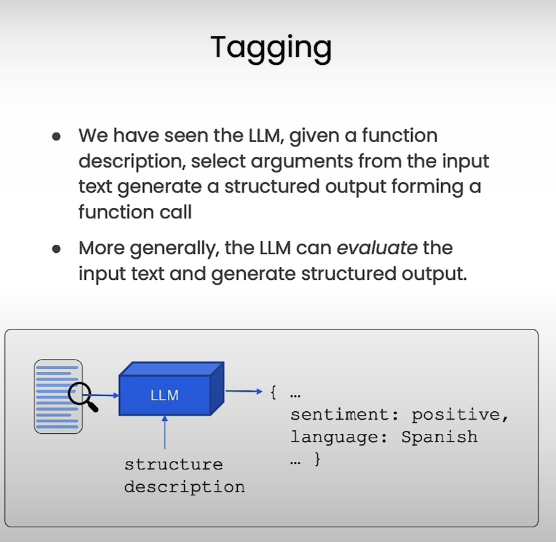

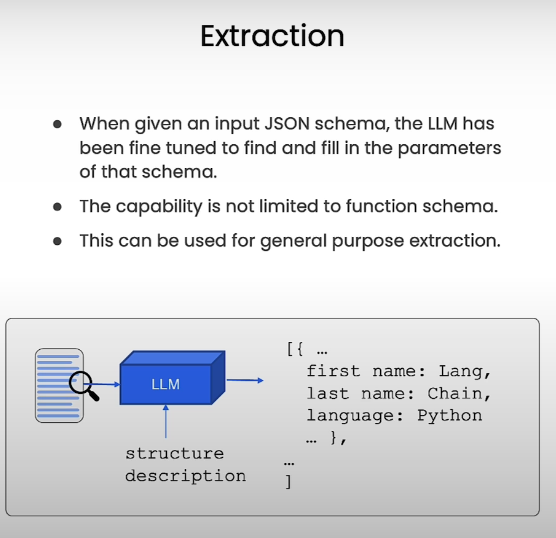

In [1]:
from typing import List
from pydantic import BaseModel, Field
from langchain_core.utils.function_calling import convert_to_openai_function

In [2]:
class Tagging(BaseModel):
    """Tag the piece of text with particular info."""
    sentiment: str = Field(description="sentiment of text, should be `pos`, `neg`, or `neutral`")
    language: str = Field(description="language of text (should be ISO 639-1 code)")

In [3]:
convert_to_openai_function(Tagging)

{'name': 'Tagging',
 'description': 'Tag the piece of text with particular info.',
 'parameters': {'type': 'object',
  'properties': {'sentiment': {'description': 'sentiment of text, should be `pos`, `neg`, or `neutral`',
    'type': 'string'},
   'language': {'description': 'language of text (should be ISO 639-1 code)',
    'type': 'string'}},
  'required': ['sentiment', 'language']}}

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [5]:
model = ChatOpenAI(temperature=0) 
# we are tagging things, so we don't want the model to be too creative and non-deterministic

In [6]:
tagging_functions = [convert_to_openai_function(Tagging)]

In [7]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Think carefully, and then tag the text as instructed"),
    ("user", "{input}")
])

In [8]:
model_with_functions = model.bind(
    functions=tagging_functions,
    function_call={"name": "Tagging"}
)

In [9]:
tagging_chain = prompt | model_with_functions

In [10]:
tagging_chain.invoke({"input": "I love langchain"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"sentiment":"pos","language":"en"}', 'name': 'Tagging'}}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 108, 'total_tokens': 118}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-e03f4497-2d96-4bcd-9f31-d818eed1b476-0', usage_metadata={'input_tokens': 108, 'output_tokens': 10, 'total_tokens': 118})

In [11]:
# non mi piace questo cibo = I don't like this food
tagging_chain.invoke({"input": "non mi piace questo cibo"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"sentiment":"neg","language":"it"}', 'name': 'Tagging'}}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 111, 'total_tokens': 121}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-33dd2d62-7e7e-4ecb-a395-7777cbffc862-0', usage_metadata={'input_tokens': 111, 'output_tokens': 10, 'total_tokens': 121})

In [12]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

In [13]:
tagging_chain = prompt | model_with_functions | JsonOutputFunctionsParser()

In [14]:
tagging_chain.invoke({"input": "non mi piace questo cibo"})

{'sentiment': 'neg', 'language': 'it'}

In [16]:
tagging_chain.invoke({"input": "我叫黄帅哥"})

{'sentiment': 'neutral', 'language': 'zh'}

## Extraction

Extraction is similar to tagging, but used for extracting multiple pieces of information.

In [17]:
from typing import Optional
class Person(BaseModel):
    """Information about a person."""
    name: str = Field(description="person's name")
    age: Optional[int] = Field(description="person's age")

In [18]:
class Information(BaseModel):
    """Information to extract."""
    people: List[Person] = Field(description="List of info about people")

In [19]:
convert_to_openai_function(Information)

{'name': 'Information',
 'description': 'Information to extract.',
 'parameters': {'type': 'object',
  'properties': {'people': {'description': 'List of info about people',
    'type': 'array',
    'items': {'description': 'Information about a person.',
     'type': 'object',
     'properties': {'name': {'description': "person's name", 'type': 'string'},
      'age': {'description': "person's age", 'type': 'integer'}},
     'required': ['name']}}},
  'required': ['people']}}

In [20]:
extraction_functions = [convert_to_openai_function(Information)]
extraction_model = model.bind(functions=extraction_functions, function_call={"name": "Information"})

In [21]:
extraction_model.invoke("Joe is 30, his mom is Martha")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"people":[{"name":"Joe","age":30},{"name":"Martha"}]}', 'name': 'Information'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 93, 'total_tokens': 110}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-6c54305f-7f68-442a-aad7-5ecb337c50a0-0', usage_metadata={'input_tokens': 93, 'output_tokens': 17, 'total_tokens': 110})

In [22]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Extract the relevant information, if not explicitly provided do not guess. Extract partial info"),
    ("human", "{input}")
])

In [23]:
extraction_chain = prompt | extraction_model

In [24]:
extraction_chain.invoke({"input": "Joe is 30, his mom is Martha"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"people":[{"name":"Joe","age":30},{"name":"Martha"}]}', 'name': 'Information'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 110, 'total_tokens': 127}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-51dd53b1-d910-4ee8-afdf-e98264df820e-0', usage_metadata={'input_tokens': 110, 'output_tokens': 17, 'total_tokens': 127})

In [25]:
extraction_chain = prompt | extraction_model | JsonOutputFunctionsParser()

In [26]:
extraction_chain.invoke({"input": "Joe is 30, his mom is Martha"})

{'people': [{'name': 'Joe', 'age': 30}, {'name': 'Martha'}]}

In [27]:
from langchain.output_parsers.openai_functions import JsonKeyOutputFunctionsParser

In [28]:
extraction_chain = prompt | extraction_model | JsonKeyOutputFunctionsParser(key_name="people")

In [29]:
extraction_chain.invoke({"input": "Joe is 30, his mom is Martha"})

[{'name': 'Joe', 'age': 30}, {'name': 'Martha'}]

## Doing it for real

We can apply tagging to a larger body of text.

For example, let's load this blog post and extract tag information from a sub-set of the text.

In [30]:
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
documents = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [31]:
doc = documents[0]

In [32]:
doc

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content='\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autono

In [33]:
page_content = doc.page_content[:10000]

In [34]:
print(page_content[:1000])







LLM Powered Autonomous Agents | Lil'Log







































Lil'Log






















Posts




Archive




Search




Tags




FAQ




emojisearch.app









      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


 


Table of Contents



Agent System Overview

Component One: Planning

Task Decomposition

Self-Reflection


Component Two: Memory

Types of Memory

Maximum Inner Product Search (MIPS)


Component Three: Tool Use

Case Studies

Scientific Discovery Agent

Generative Agents Simulation

Proof-of-Concept Examples


Challenges

Citation

References





Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general

In [35]:
class Overview(BaseModel):
    """Overview of a section of text."""
    summary: str = Field(description="Provide a concise summary of the content.")
    language: str = Field(description="Provide the language that the content is written in.")
    keywords: str = Field(description="Provide keywords related to the content.")

In [36]:
overview_tagging_function = [
    convert_to_openai_function(Overview)
]
tagging_model = model.bind(
    functions=overview_tagging_function,
    function_call={"name":"Overview"}
)
tagging_chain = prompt | tagging_model | JsonOutputFunctionsParser()

In [37]:
tagging_chain.invoke({"input": page_content})

{'summary': 'The article discusses the concept of building autonomous agents powered by LLM (large language model) as the core controller. It covers components like planning, memory, and tool use, along with challenges and references.',
 'language': 'English',
 'keywords': 'LLM, autonomous agents, planning, memory, tool use, challenges, references'}

In [51]:
class Paper(BaseModel):
    """Information about papers mentioned."""
    title: str
    author: str


class Info(BaseModel):
    """Information to extract"""
    papers: List[Paper]

In [52]:
paper_extraction_function = [
    convert_to_openai_function(Info)
]
extraction_model = model.bind(
    functions=paper_extraction_function, 
    function_call={"name":"Info"}
)
extraction_chain = prompt | extraction_model | JsonKeyOutputFunctionsParser(key_name="papers")

In [53]:
extraction_chain.invoke({"input": page_content})

[{'title': 'Chain of thought (CoT; Wei et al. 2022)', 'author': 'Wei et al.'},
 {'title': 'Tree of Thoughts (Yao et al. 2023)', 'author': 'Yao et al.'},
 {'title': 'LLM+P (Liu et al. 2023)', 'author': 'Liu et al.'},
 {'title': 'ReAct (Yao et al. 2023)', 'author': 'Yao et al.'},
 {'title': 'Reflexion (Shinn & Labash 2023)', 'author': 'Shinn & Labash'},
 {'title': 'Chain of Hindsight (CoH; Liu et al. 2023)',
  'author': 'Liu et al.'},
 {'title': 'Algorithm Distillation (AD; Laskin et al. 2023)',
  'author': 'Laskin et al.'}]

In [54]:
template = """A article will be passed to you. Extract from it all papers that are mentioned by this article. 

Do not extract the name of the article itself. If no papers are mentioned that's fine - you don't need to extract any! Just return an empty list.

Do not make up or guess ANY extra information. Only extract what exactly is in the text."""

prompt = ChatPromptTemplate.from_messages([
    ("system", template),
    ("human", "{input}")
])

In [42]:
extraction_chain = prompt | extraction_model | JsonKeyOutputFunctionsParser(key_name="papers")

In [43]:
extraction_chain.invoke({"input": page_content})

[{'title': 'Chain of thought (CoT; Wei et al. 2022)'},
 {'title': 'Tree of Thoughts (Yao et al. 2023)'},
 {'title': 'LLM+P (Liu et al. 2023)'},
 {'title': 'ReAct (Yao et al. 2023)'},
 {'title': 'Reflexion (Shinn & Labash 2023)'},
 {'title': 'Chain of Hindsight (CoH; Liu et al. 2023)'},
 {'title': 'Algorithm Distillation (AD; Laskin et al. 2023)'}]

In [44]:
extraction_chain.invoke({"input": "hi"})

[]

In [55]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_overlap=0)

In [56]:
splits = text_splitter.split_text(doc.page_content)

In [57]:
len(splits)

15

In [58]:
def flatten(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

In [59]:
flatten([[1, 2], [3, 4]])

[1, 2, 3, 4]

In [50]:
print(splits[0])

LLM Powered Autonomous Agents | Lil'Log







































Lil'Log






















Posts




Archive




Search




Tags




FAQ




emojisearch.app









      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


 


Table of Contents



Agent System Overview

Component One: Planning

Task Decomposition

Self-Reflection


Component Two: Memory

Types of Memory

Maximum Inner Product Search (MIPS)


Component Three: Tool Use

Case Studies

Scientific Discovery Agent

Generative Agents Simulation

Proof-of-Concept Examples


Challenges

Citation

References





Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general probl

In [60]:
from langchain.schema.runnable import RunnableLambda

In [61]:
prep = RunnableLambda(
    lambda x: [{"input": doc} for doc in text_splitter.split_text(x)]
)

In [62]:
prep.invoke("hi")

[{'input': 'hi'}]

In [65]:
chain = prep | extraction_chain.map() 

In [66]:
chain.invoke(doc.page_content)

[[{'title': 'AutoGPT', 'author': 'Unknown'},
  {'title': 'GPT-Engineer', 'author': 'Unknown'},
  {'title': 'BabyAGI', 'author': 'Unknown'}],
 [{'title': 'Chain of thought', 'author': 'Wei et al. 2022'},
  {'title': 'Tree of Thoughts', 'author': 'Yao et al. 2023'},
  {'title': 'LLM+P', 'author': 'Liu et al. 2023'},
  {'title': 'ReAct', 'author': 'Yao et al. 2023'},
  {'title': 'Reflexion', 'author': 'Shinn & Labash 2023'}],
 [{'title': 'Chain of Hindsight', 'author': 'Liu et al. 2023'},
  {'title': 'Algorithm Distillation', 'author': 'Laskin et al. 2023'}],
 [{'title': 'Laskin et al. 2023', 'author': 'Laskin'}],
 [{'title': 'Google Blog', 'author': 'Google'},
  {'title': 'ann-benchmarks.com', 'author': 'Unknown'}],
 [{'title': 'MRKL (Karpas et al. 2022)', 'author': 'Karpas et al.'},
  {'title': 'TALM (Tool Augmented Language Models; Parisi et al. 2022)',
   'author': 'Parisi et al.'},
  {'title': 'Toolformer (Schick et al. 2023)', 'author': 'Schick et al.'},
  {'title': 'HuggingGPT (She

In [67]:
chain = prep | extraction_chain.map() | flatten
chain.invoke(doc.page_content)

[{'title': 'AutoGPT', 'author': 'Unknown'},
 {'title': 'GPT-Engineer', 'author': 'Unknown'},
 {'title': 'BabyAGI', 'author': 'Unknown'},
 {'title': 'Chain of thought', 'author': 'Wei et al. 2022'},
 {'title': 'Tree of Thoughts', 'author': 'Yao et al. 2023'},
 {'title': 'LLM+P', 'author': 'Liu et al. 2023'},
 {'title': 'ReAct', 'author': 'Yao et al. 2023'},
 {'title': 'Reflexion', 'author': 'Shinn & Labash 2023'},
 {'title': 'Chain of Hindsight', 'author': 'Liu et al. 2023'},
 {'title': 'Algorithm Distillation', 'author': 'Laskin et al. 2023'},
 {'title': 'Laskin et al. 2023', 'author': 'Laskin'},
 {'title': 'Google Blog', 'author': 'Google'},
 {'title': 'ann-benchmarks.com', 'author': 'Unknown'},
 {'title': 'MRKL (Karpas et al. 2022)', 'author': 'Karpas et al.'},
 {'title': 'TALM (Tool Augmented Language Models; Parisi et al. 2022)',
  'author': 'Parisi et al.'},
 {'title': 'Toolformer (Schick et al. 2023)', 'author': 'Schick et al.'},
 {'title': 'HuggingGPT (Shen et al. 2023)', 'autho